In [1]:
# Checkout www.pygimli.org for more examples
%matplotlib inline


VES inversion for a blocky model
================================

This tutorial shows how an built-in forward operator is used for inversion.
A DC 1D (VES) modelling is used to generate data, noisify and invert them.


We import numpy, matplotlib and the 1D plotting function



In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pygimli as pg
from pygimli.viewer.mpl import drawModel1D

some definitions before (model, data and error)



In [3]:
nlay = 4  # number of layers
lam = 200.  # (initial) regularization parameter
errPerc = 3.  # relative error of 3 percent
ab2 = np.logspace(-1, 2, 50)  # AB/2 distance (current electrodes)
mn2 = ab2 / 3.  # MN/2 distance (potential electrodes)

initialize the forward modelling operator



In [4]:
f = pg.core.DC1dModelling(nlay, ab2, mn2)

other ways are by specifying a Data Container or am/an/bm/bn distances



In [5]:
synres = [100., 500., 20., 800.]  # synthetic resistivity
synthk = [0.5, 3.5, 6.]  # synthetic thickness (nlay-th layer is infinite)

the forward operator can be called by f.response(model) or simply f(model)



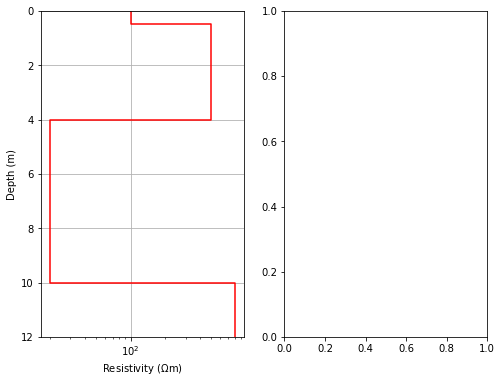

In [8]:
rhoa = f(synthk+synres)
fig, ax = plt.subplots(ncols=2, figsize=(8, 6))  # two-column figure
drawModel1D(ax[0], synthk, synres, plot='semilogx', color='r')

create some transformations used for inversion



In [ ]:
transThk = pg.trans.TransLog()  # log-transform ensures thk>0
transRho = pg.trans.TransLogLU(1, 1000)  # lower and upper bound
transRhoa = pg.trans.TransLog()  # log transformation for data

set model transformation for thickness and resistivity



In [ ]:
f.region(0).setTransModel(transThk)  # 0=thickness
f.region(1).setTransModel(transRho)  # 1=resistivity

generate start model values from median app. resistivity & spread



In [ ]:
paraDepth = max(ab2) / 3.  # rule-of-thumb for Wenner/Schlumberger
f.region(0).setStartValue(paraDepth / nlay / 2)
f.region(1).setStartValue(np.median(rhoa))

set up inversion



In [ ]:
inv = pg.core.Inversion(rhoa, f, transRhoa, True)  # data vector, fop, verbose
# could also be set by inv.setTransData(transRhoa)

set error model, regularization strength and Marquardt scheme



In [ ]:
inv.setRelativeError(errPerc / 100.0)  # alternative: setAbsoluteError in Ohmm
inv.setLambda(lam)  # (initial) regularization parameter
inv.setMarquardtScheme(0.9)  # decrease lambda by factor 0.9
model = f.createStartVector()  # creates from region start value
model[nlay] *= 1.5  # change default model by changing 2nd layer resistivity
inv.setModel(model)  #

run actual inversion and extract resistivity and thickness



In [ ]:
model = inv.run()  # result is a pg.Vector, but compatible to numpy array
res, thk = model[nlay-1:nlay*2-1], model[0:nlay-1]
print('rrms={:.2f}%, chi^2={:.3f}'.format(inv.relrms(), inv.chi2()))

show estimated&synthetic models and data with model response in 2 subplots



In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 6))  # two-column figure
drawModel1D(ax[0], synthk, synres, plot='semilogx', color='r')
drawModel1D(ax[0], thk, res, color='b')
ax[0].grid(True, which='both')
ax[0].set_ylabel('z (m)')
ax[0].set_xlabel(r'$\rho$ ($\Omega$m)')
ax[1].loglog(rhoa, ab2, 'rx-', label='data')  # sounding curve
ax[1].loglog(inv.response(), ab2, 'b-', label='response')
ax[1].set_ylim((max(ab2), min(ab2)))  # downwards according to penetration
ax[1].grid(True, which='both')
ax[1].set_xlabel(r'$\rho_a$ ($\Omega$m)')
ax[1].set_ylabel('AB/2 (m)')
ax[1].legend(loc='best')
plt.show()